# Анализ убытков приложения ProcrastinatePro+

### Описание проекта

Развлекательное приложение Procrastinate Pro+ последние несколько месяцев терпит убытки, несмотря на большие вложения в рекламу. В рамках исследования предстоит разобраться в причинах этого явления и помочь компании выйти в плюс.
В нашем распоряжении имеются данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях
* выгрузка их покупок за этот период
* рекламные расходы

Для выполнения поставленной задачи мы проанализируем:
* откуда приходят пользователи и какими устройствами они пользуются
* сколько стоит привлечение пользователей из различных рекламных каналов
* сколько денег приносит каждый клиент
* когда расходы на привлечение клиента окупаются
* какие факторы мешают привлечению клиентов

### Загрузка данных и подготовка к анализу

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


In [2]:
#чтение данных и сохранение в переменные
visits, orders, costs = (
    pd.read_csv('1.csv'),
    pd.read_csv('2.csv'),
    pd.read_csv('3.csv'),
)

Для проведения анализа в нашем распоряжении имеется три датасета.

1.csv (лог сервера с информацией о посещениях сайта):

2.csv (информация о заказах):

3.csv (информация о расходах на рекламу):


#### Предобработка датасета visits

In [3]:
display(visits.head())
visits.info()
#проверка на наличие пропусков
visits.isna().sum()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [4]:
#проверка на наличие дубликатов
visits.duplicated().sum()

0

In [5]:
#получение списка уникальных значений столбца
visits['Region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [6]:
#получение списка уникальных значений столбца
visits['Device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [7]:
#получение списка уникальных значений столбца
visits['Channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Пропуски и дубликаты в датасете visits отсутствуют, но необходимо скорректировать некоторые моменты. Для удобства анализа будет целесообразно привести все названия столбцов, как и содержимое некоторых столбцов к строчному написанию, а так же привести названия столбцов к стилю snake case. После знакомства с данным в столбце Region, для удобства анализа считаем целесообразным переименовать United States в USA, а так же привести тип данных в столбцах Session Start и Session End к правильному типу для дальнейше работы с датами.

In [8]:
#перевод текстовых данных в строчный регистр
visits.columns = visits.columns.str.lower()
visits['region'] = visits['region'].str.lower()
visits['device'] = visits['device'].str.lower()
visits['channel'] = visits['channel'].str.lower()

In [9]:
#приведение текстовых данных к стилю snake case
visits.columns = (visits.columns.str.replace(' ', '_'))
visits['region'] = (visits['region'].str.replace('united states', 'usa'))

In [10]:
#изменение типов данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [11]:
#отображение данных для проверки произведенных изменений
display(visits.head())
visits.info()

,user_id,region,device,channel,session_start,session_end
0,981449118918,usa,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,usa,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,usa,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,usa,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,usa,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


#### Предобработка датасета orders

In [12]:
display(orders.head())
orders.info()
#проверка на наличие пропусков
orders.isna().sum()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [13]:
#проверка на наличие дубликатов
orders.duplicated().sum()

0

Пропуски и дубликаты в датасете orders отсутствуют. Для удобства анализа названия столбцов к строчному написанию в "змеином" регистре. В столбце Event Dt необходимо изменить тип данных.

In [14]:
orders.columns = (orders.columns.str.replace(' ', '_')).str.lower()

In [15]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [16]:
display(orders.head())
orders.info()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


#### Предобработка датасета costs

In [17]:
display(costs.head())
costs.info()
#проверка на наличие пропусков
costs.isna().sum()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt         0
Channel    0
costs      0
dtype: int64

In [18]:
#проверка на наличие дубликатов
costs.duplicated().sum()

0

In [19]:
costs['Channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Как и в случае с первыми двумя датасетами необходимо изменить тип данных в столбце с датами - dt и привести названия столбцов к строчному написанию. Кроме того, содержимое столбца Channel, если оставить написания каналов в таком виде, как они пристутствуют сейчас, гарантированно приведет к орфографическим ошибкам и проблемам в анализе. Поэтому все значения в данном столбце так же будут приведены к строчному написанию. 

In [20]:
costs.columns = costs.columns.str.lower()
costs['channel'] = costs['channel'].str.lower()

In [21]:
#изменение типов данных
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [22]:
#проверка произведенных изменений
display(costs.head())
costs.info()

,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


#### Вывод по разделу

После знакомства с полученым датасетом, были произведены необходимые операции для проведения последующего анализа. Данные были проанализированны на наличие пропусков и дубликатов - их нет. Были изменены типы данных в столбцах с датами и временем. Названия столбцов были приведены к единому стандарту - строчное написание в "змеином" регистре. В столбцах с названиями рекламных каналов привлечения были представлены сложные сочетания строчных и заглавных букв в названиях, для минимизации ошибок мы посчитали целесообразным привести их к единому, строчному стандарту написания. 

В результате мы имеем чистые и подготовленные к анализу данные.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Для проведения исследовательского анализа создаем функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция для создания пользовательских профилей - get_profiles()

In [23]:
def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта удержания - get_retention()

In [24]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта конверсии - get_conversion()

In [25]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта LTV и ROI - get_ltv()

In [26]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция для сглаживания данных - filter_data()

In [27]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для построения графика Retention Rate - plot_retention()

In [28]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция для построения графика конверсии - plot_conversion()

In [29]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция для визуализации LTV и ROI - plot_ltv_roi()

In [30]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных
В рамках проведения исследовательского анализа выполним следующие задачи:
- Составим профили пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

#### Профили пользователей

In [31]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,usa,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iphone,usa,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,usa,2019-10-02,2019-10-01,False,0.230769


In [32]:
print(f'Минимальная дата привлечения пользователей - {profiles.first_ts.min()}, максимальная - {profiles.first_ts.max()}.')

Минимальная дата привлечения пользователей - 2019-05-01 00:00:41, максимальная - 2019-10-27 23:59:04.


In [33]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

В датафрейме присутствуют пользователи пришедшие с 01.05.2019 по 27.10.2019.
За точку наблюдения мы принимаем дату - 01.11.2019, горизонт анализа - 14 дней.

#### Страновое распределение пользователей

In [34]:
#страны представленные в датафрейме
print(profiles.region.unique())

['usa' 'france' 'germany' 'uk']


In [35]:
region_users = (
    profiles.groupby('region')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('region')['user_id'].nunique().reset_index(), 
           on = 'region', how = 'left')
)
region_users.set_axis(['region', 'total_users', 'payers'], axis='columns', inplace=True)
region_users['payer_rate'] = region_users.payers / region_users.total_users
display(region_users.sort_values(by='payer_rate', ascending=False))

,region,total_users,payers,payer_rate
3,usa,100002,6902,0.069019
1,germany,14981,616,0.041119
2,uk,17575,700,0.039829
0,france,17450,663,0.037994


В нашей базе данных присутствуют плательщики из четырех стран: Великобритания, Германия, США и Франция. Наибольшее число пользователей приложения из США (~67%), за которыми и лучшее соотношение платящих пользователей ~ 7%. 
В странах Европы доля платящих пользователей находится в районе 4%.

#### Распределение пользователей по используемым устройствам

In [36]:
#устройства пользоватей
print(profiles.device.unique())

['mac' 'iphone' 'pc' 'android']


In [37]:
device_users = (
    profiles.groupby('device')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('device')['user_id'].nunique().reset_index(), on = 'device', how = 'left')
)
device_users.set_axis(['device', 'total_users', 'payers'], axis='columns', inplace=True)
device_users['payer_rate'] = device_users.payers / device_users.total_users
display(device_users.sort_values(by='payer_rate', ascending=False))

,device,total_users,payers,payer_rate
2,mac,30042,1912,0.063644
1,iphone,54479,3382,0.062079
0,android,35032,2050,0.058518
3,pc,30455,1537,0.050468


Наибольшее число пользователей приходит в приложение с iPhone - 36%, однако по доле платящих пользователей, айфон чуть проигрывает Mac ~ 6.4%, в то время как у iPhone ~ 6.2%

#### Источники привлечения пользователей

In [38]:
#рекламные каналы привлечения пользователей
print(profiles.channel.unique())

['faceboom' 'organic' 'adnonsense' 'yrabbit' 'mediatornado'
 'rocketsuperads' 'leapbob' 'tiptop' 'wahoonetbanner' 'opplecreativemedia'
 'lambdamediaads']


In [39]:
ch_users = (
    profiles.groupby('channel')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('channel')['user_id'].nunique().reset_index(), on = 'channel', how = 'left')
)
ch_users.set_axis(['channel', 'total_users', 'payers'], axis='columns', inplace=True)
ch_users['payer_rate'] = ch_users.payers / ch_users.total_users
display(ch_users.sort_values(by='payer_rate', ascending=False))

,channel,total_users,payers,payer_rate
1,faceboom,29144,3557,0.122049
0,adnonsense,3880,440,0.113402
2,lambdamediaads,2149,225,0.104700
8,tiptop,19561,1878,0.096007
7,rocketsuperads,4448,352,0.079137
9,wahoonetbanner,8553,453,0.052964
10,yrabbit,4312,165,0.038265
4,mediatornado,4364,156,0.035747
3,leapbob,8553,262,0.030633
5,opplecreativemedia,8605,233,0.027077


Почти 38% пользователей пришли в приложение органическим путем, сами. Однако, этот канал находится на последнем месте по доле платящих пользователей. Если не брать во внимание пользователей пришедших естественым путем, то самый продуктивный и эффективный канал привлечения это faceboom - 19% всех пользователей и 12% платящих пользователей приходится именно на этот канал.

#### Вывод по разделу

Пользователи нашего приложения приходят из четырёх стран: Великобритания, Германия, США и Франция. Наибольшее число пользователей приложения из США (~67%), за которыми и лучшее соотношение платящих пользователей ~ 7%. В странах Европы доля платящих пользователей находится в районе 4%.

Пользователи пользуются 4 типами устройств для входа в приложение: Android, iPhone, MAC, PC. Наибольшее число пользователей приходит в приложение с iPhone - 36%, однако по доле платящих пользователей, айфон чуть проигрывает Mac ~ 6.4%, в то время как у iPhone ~ 6.2%

Мы имеем 11 каналов привлечения пользователей (включая "органический" - пользователей, которые нашли наше приложение сами). Если не брать во внимание пользователей пришедших естественым путем, то самый продуктивный и эффективный канал привлечения это faceboom - 19% всех пользователей и 12% платящих пользователей приходится именно на этот канал.

### Маркетинг
Проанализируем данные по маркетинговым активностям.
- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам.
- Построим визуализацию динамики изменения расходов во времени по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

#### Общая сумма расходов на маркетинг

In [40]:
print(f'Общая сумма затрат на маркетинг - {round(costs.costs.sum())} у.е.')

Общая сумма затрат на маркетинг - 105497 у.е.


#### Распределение трат по рекламным источникам

In [41]:
costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()

,channel,costs
0,tiptop,54751.30
1,faceboom,32445.60
2,wahoonetbanner,5151.00
3,adnonsense,3911.25
4,opplecreativemedia,2151.25
5,rocketsuperads,1833.00
6,leapbob,1797.60
7,lambdamediaads,1557.60
8,mediatornado,954.48
9,yrabbit,944.22


#### Визуализация динамики изменения расходов на привлечение пользователей по каждому источнику

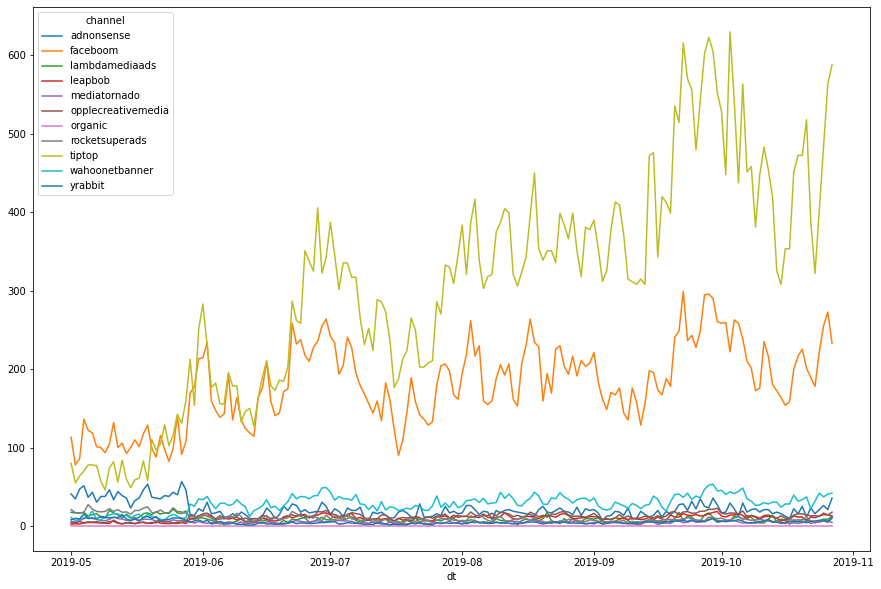

In [42]:
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(figsize=(15,10)),
plt.show()

#### Средняя стоимость привлечения пользователей из разных источников

In [43]:
ad_costs = ch_users.merge(costs.groupby('channel')['costs'].sum().reset_index(), on = 'channel', how = 'left')
#исключаем органически пришедших пользователей
ad_costs = ad_costs.query('channel != "organic"')
#средняя стоимость привлечения пользователя
ad_costs['cac_costs'] = ad_costs.costs / ad_costs.total_users
#средняя стоимость привлечения платящего пользователя
ad_costs['acq_costs'] = ad_costs.costs / ad_costs.payers
ad_costs.sort_values(by='cac_costs', ascending=False)

,channel,total_users,payers,payer_rate,costs,cac_costs,acq_costs
8,tiptop,19561,1878,0.096007,54751.30,2.799003,29.154047
1,faceboom,29144,3557,0.122049,32445.60,1.113286,9.121619
0,adnonsense,3880,440,0.113402,3911.25,1.008054,8.889205
2,lambdamediaads,2149,225,0.104700,1557.60,0.724802,6.922667
9,wahoonetbanner,8553,453,0.052964,5151.00,0.602245,11.370861
7,rocketsuperads,4448,352,0.079137,1833.00,0.412095,5.207386
5,opplecreativemedia,8605,233,0.027077,2151.25,0.250000,9.232833
10,yrabbit,4312,165,0.038265,944.22,0.218975,5.722545
4,mediatornado,4364,156,0.035747,954.48,0.218717,6.118462
3,leapbob,8553,262,0.030633,1797.60,0.210172,6.861069


In [44]:
print('Средний САС по всем пользователям платных каналов привлечения:', round(ad_costs['cac_costs'].mean(), 2))
print('Медианный САС по всем пользователям платных каналов привлечения:', round(ad_costs['cac_costs'].median(), 2))

Средний САС по всем пользователям платных каналов привлечения: 0.76
Медианный САС по всем пользователям платных каналов привлечения: 0.51


#### Вывод по разделу

За анализируемый период на рекламу было потрачено 105497 у.е. 
Основные траты на привлечение были сосредоточены на двух источниках - tiptop и faceboom. Рекламные расходы неуклонно и стремительно росли от месяца к месяцу именно по этим двум источникам. Остальные каналы продвижения финансировались на стабильно одинаковом уровне в течение времени. Средний CAC по всем пользователям платных каналов привлечения составляет: 0.76 у.е., медианное значние CAC: 0.51. В то время как средняя стоимость привлечения пользователя через канал tiptop достигла ~ 2.8 у.е., что существенно отличается от остальных представленных каналов продвижения приложения. На канал faceboom стоит так же обратить пристальное внимание в дальнейшем исследовании, поскольку он так же кажется неэффективным вложением средств. Для прояснения картины требуется дальнейший анализ.

### Оценка окупаемости рекламы

Проведем оценку окупаемости рекламы. Для этого поэтапно выполним следующие задачи:

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. 
- Проанализируем окупаемость рекламы с разбивкой по странам. 
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

In [45]:
#перед проведением анализа и построением графиков, уберем из анализа органических пользоваталей, поскольку они достаются нам бесплатно
profiles = profiles.query('channel !="organic"')

#### Анализ общей окупаемости рекламы

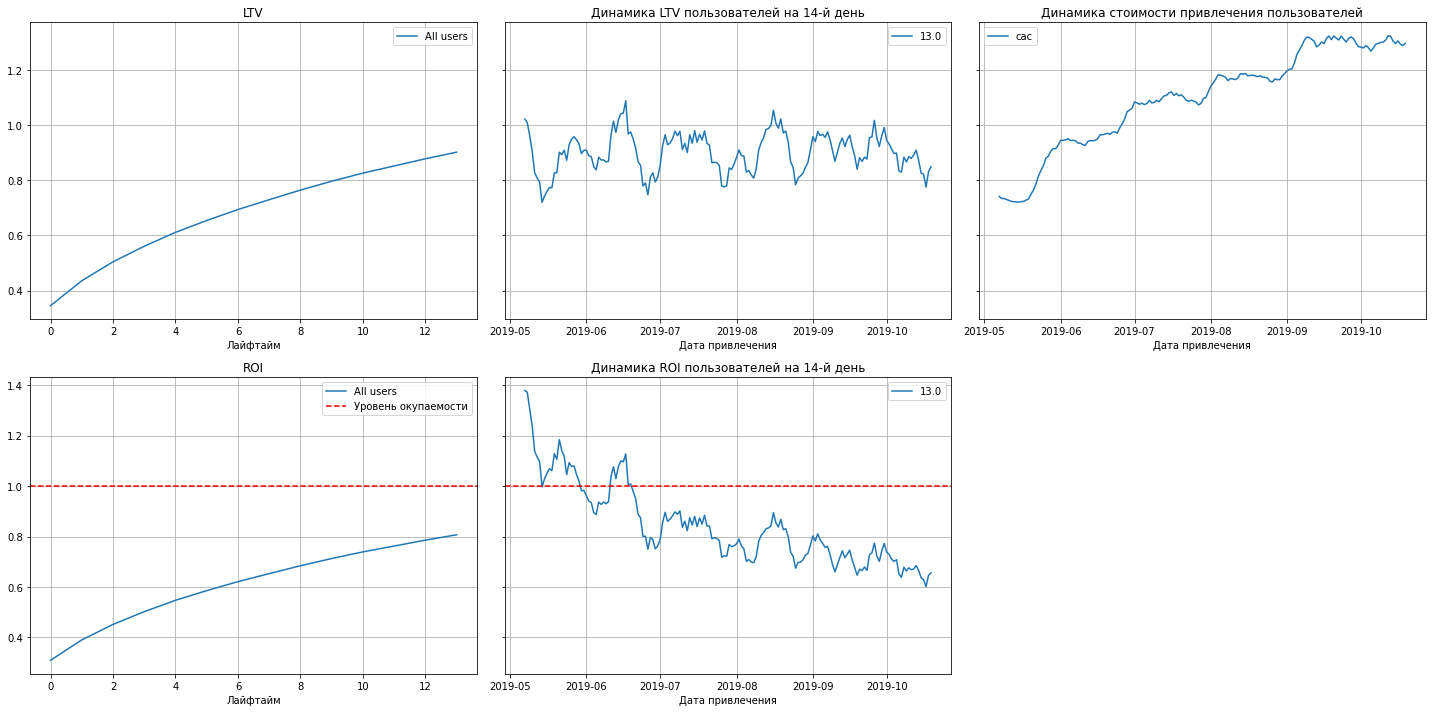

In [46]:
 ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Исходя из полученных графиков можно сделать следующие выводы. 
* Реклама не окупается. К концу второй недели показатель возврата вложений в рекламу достигает лишь 80%.
* Стоимость привлечения новых клиентов начала стремитльно расти с середины мая и тогда же начала падать окупаемость рекламных вложений. Тратить стали больше, без заметной материальной отдачи.
* LTV испытывает некоторые колебания, однако не опускается ниже определенного уровня и в целом можно назвать этот показатель стабильным

#### Конверсия и удержание пользователей и динамика их изменений.

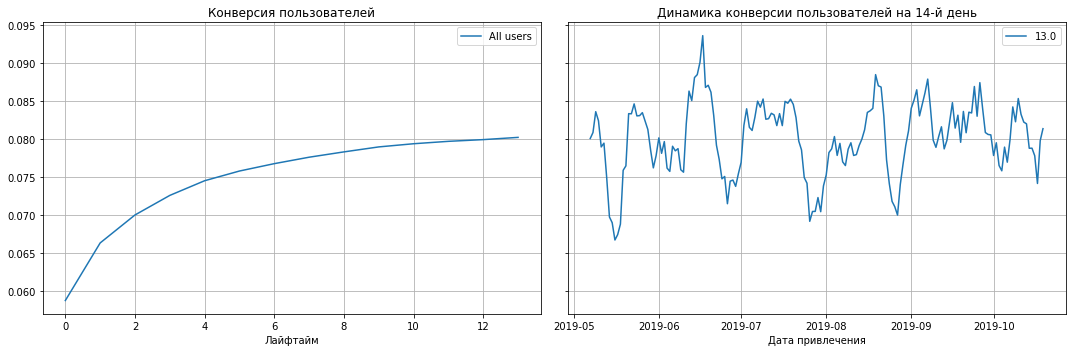

In [47]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

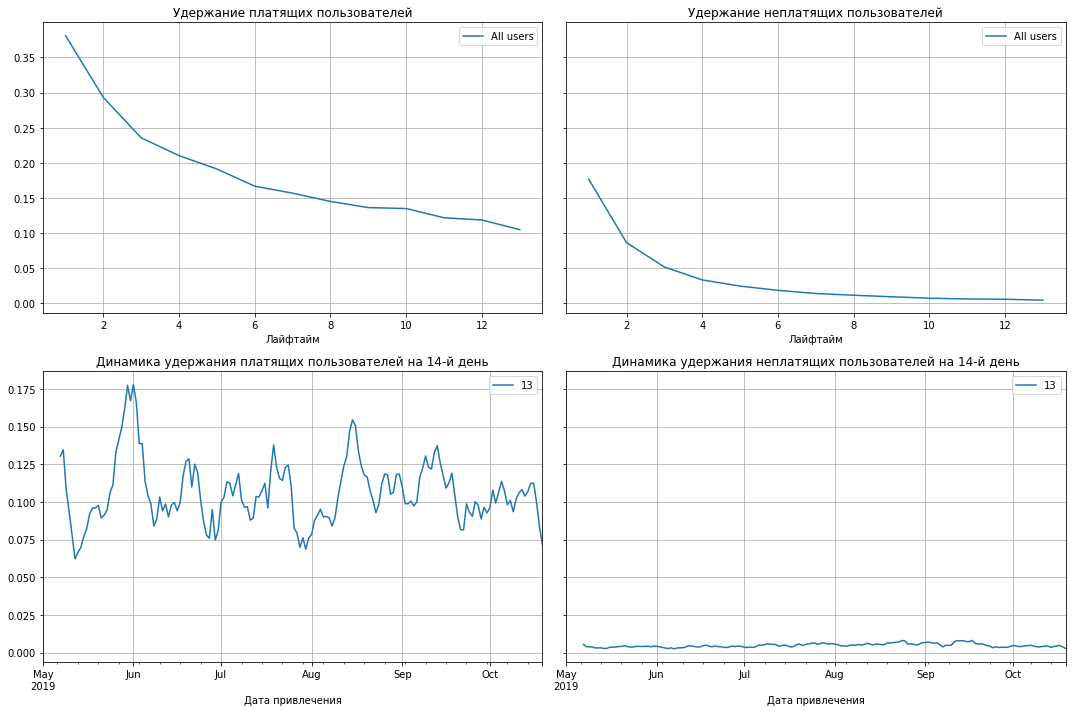

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

В целом представленыне графики не демонстирурют нам каких-то ярких аномалий. Причины неэффективных трат рекламного бюджета стоит искать в более узких параметрах.

#### Окупаемость рекламы с разбивкой по устройствам

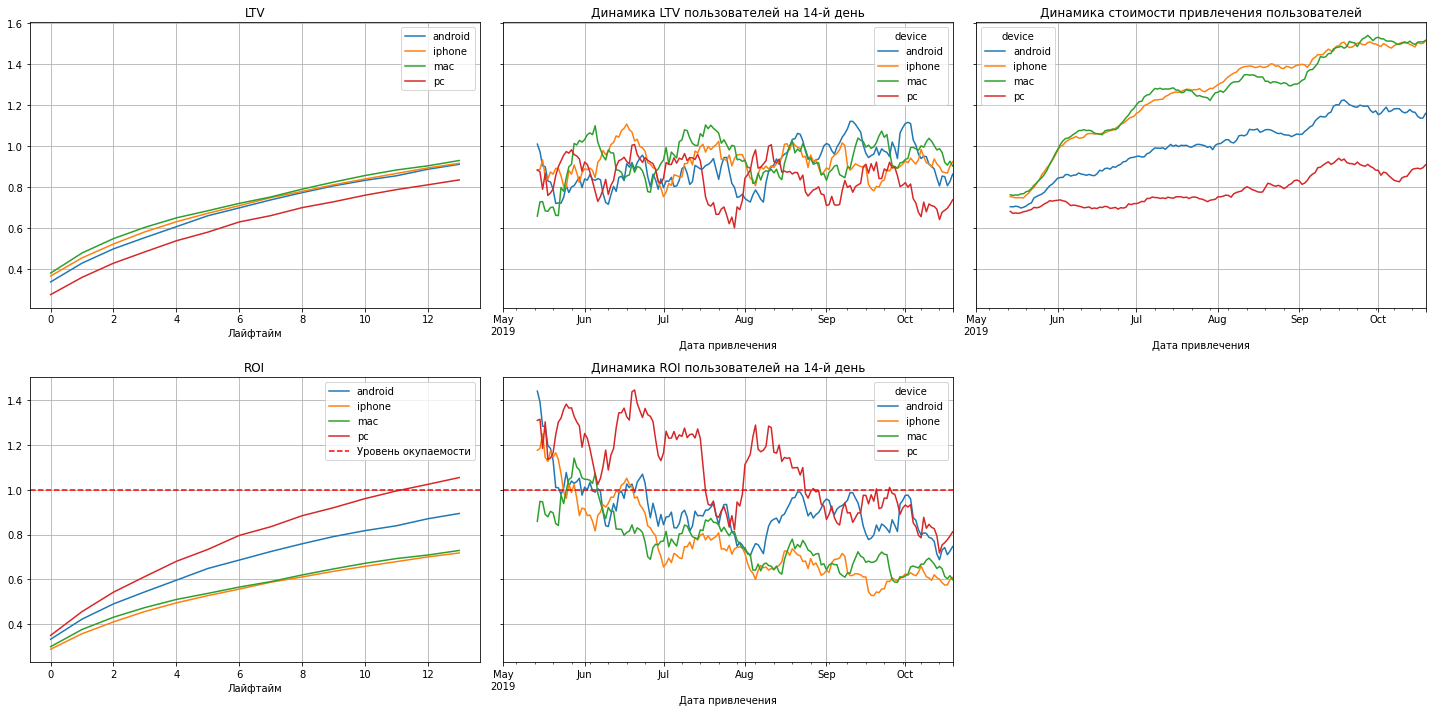

In [49]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

* LTV платформы PC чуть ниже конкурентов, остальные платформы стабильны и держатся по этому показателю рядом.
* LTV пользоваталей на 14 день испытывает равновеликие колебания, вне зависимости от используемого устройства, однако же стабилен на протяжении исследуемого периода
* Вложения в привлечение слегка окупаются только на платформе PC, при том, что стоимость привлечения у этой платформы самая низкая.
* Стоимость привлечения устройств Apple резко пошла вверх с сердины мая и с тех пор растет существенно опережая все платформы, а окупаемость при этом напротив, падает.

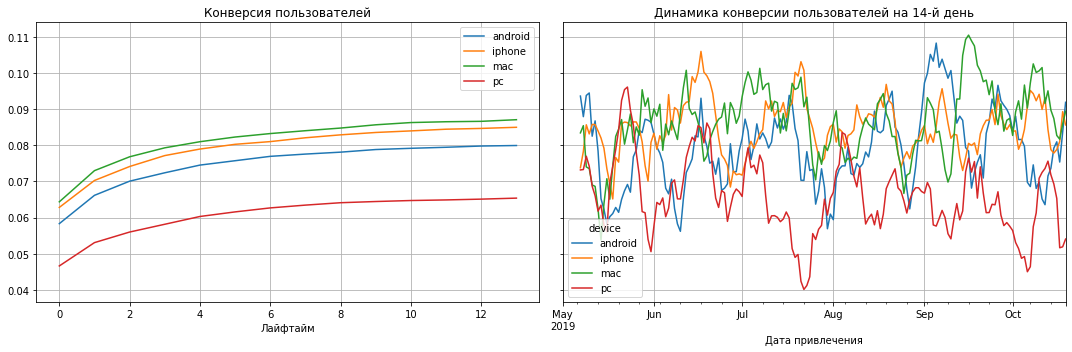

In [50]:
#изучим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Платформа PC попадает в отстающие по этому показателю.

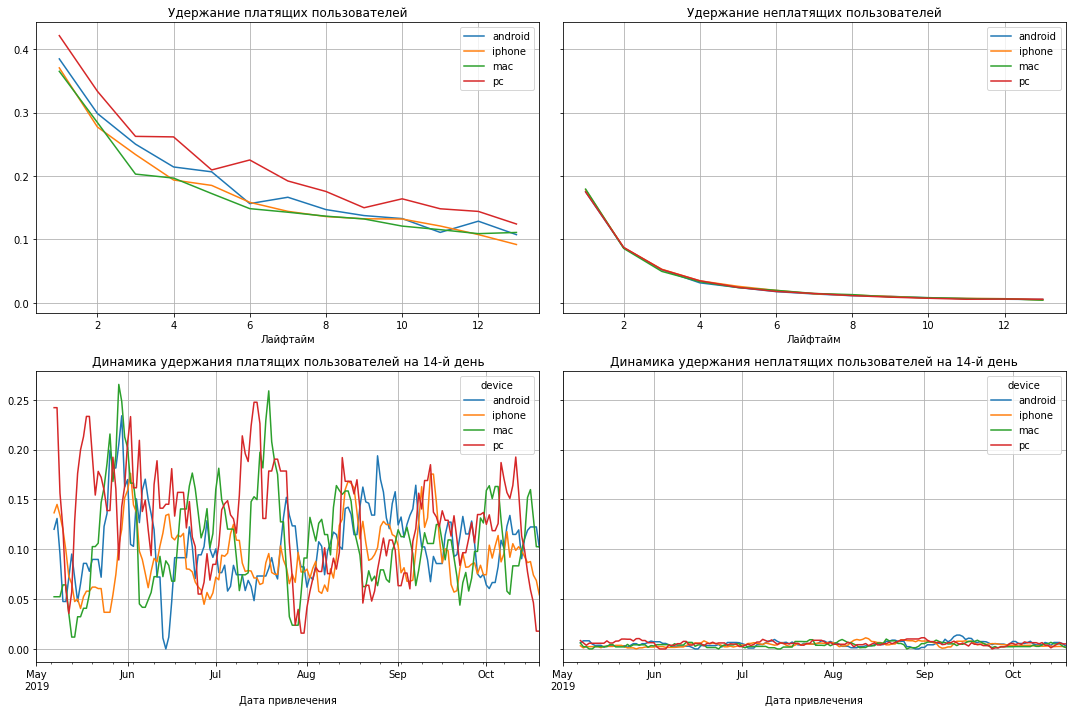

In [51]:
#изучим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

При этом, по удержанию платящих пользователей, PC демонстрирует несколько лучшие результаты, чем платформы конкуренты. Впрочем, разница между ними несущественна и можно сказать, что все домонстирируют хороший ровный уровень удержания пользоваетелей.

#### Окупаемость рекламы с разбивкой по странам

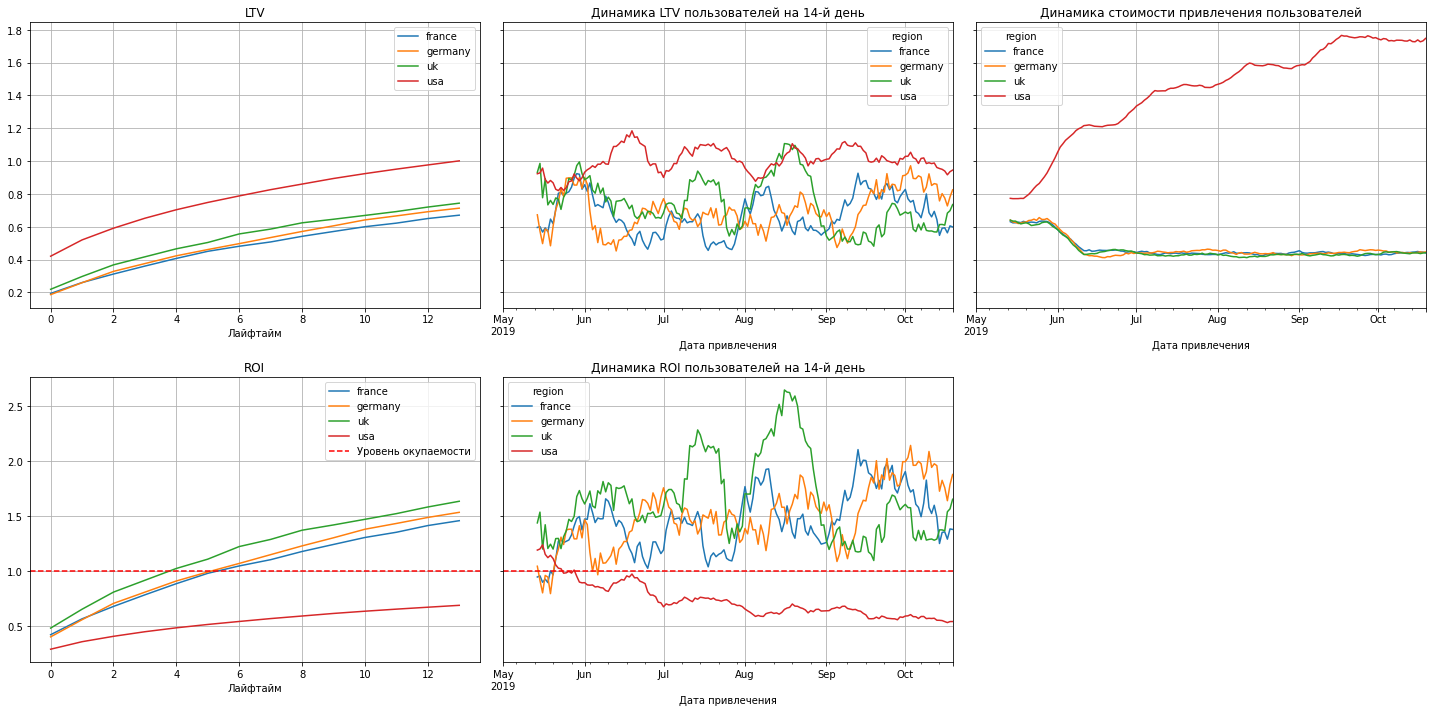

In [52]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Очень наглядно видны проблемы с рекламными вложениями на рынке США. Стоимость привлечения скачкообразно растет с сердины мая, при этом, вложения не окупаются ровно с этого же самого времени. И это не смотря на то, что LTV на рынке США выше чем в странах Европы представленных в нашем анализе. Однако, все Европейские страны окупают вложения в привлечение уже к 6 дню. При том, что рынок США у нашего приложения основной, это обуславлвает общую неуспешность рекламных вложений. Для полноты картины необходимо проанализировать окупаемость вложения в разбивке по каналам привлечения пользователей.

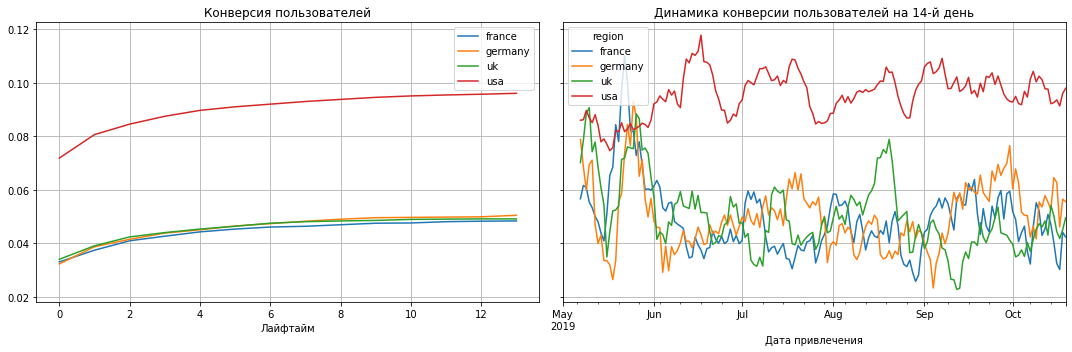

In [53]:
#изучим конверсию пользователей в разбивке по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США демонстрируют отличный и стабильный уровень конверсии, существенно превосходящий рынок Европы.

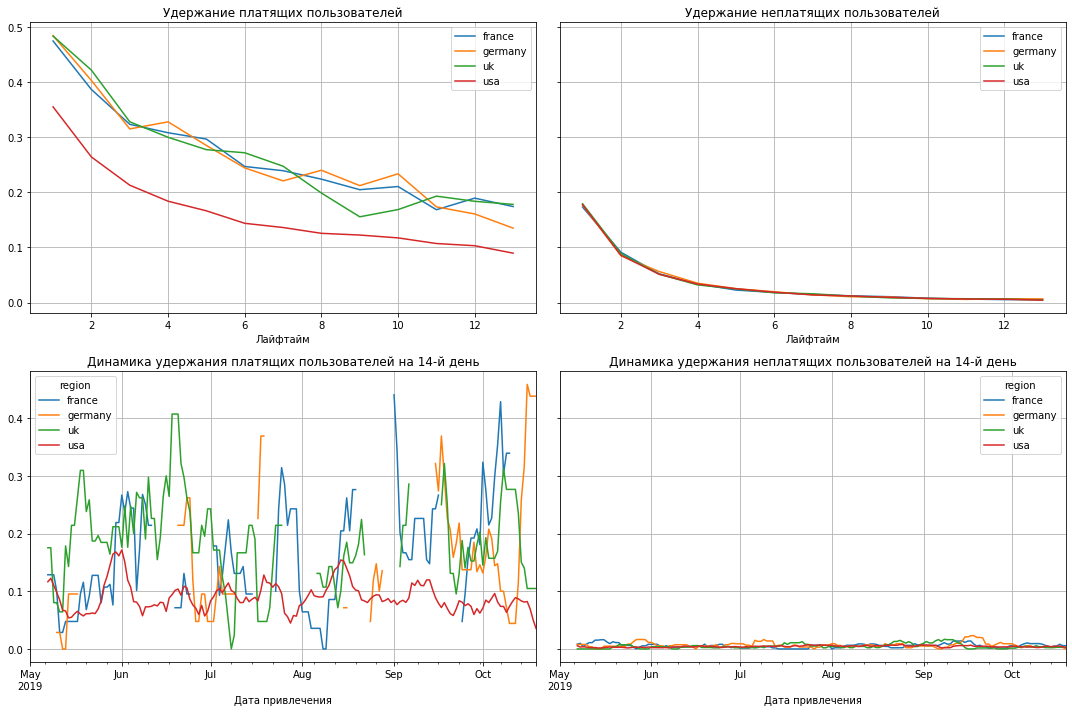

In [54]:
#изучим удержание пользователей в разбивке по странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

А вот с удержанием пользователей на рынке США явные проблемы. 

#### Окупаемость рекламы с разбивкой по каналам продвижения

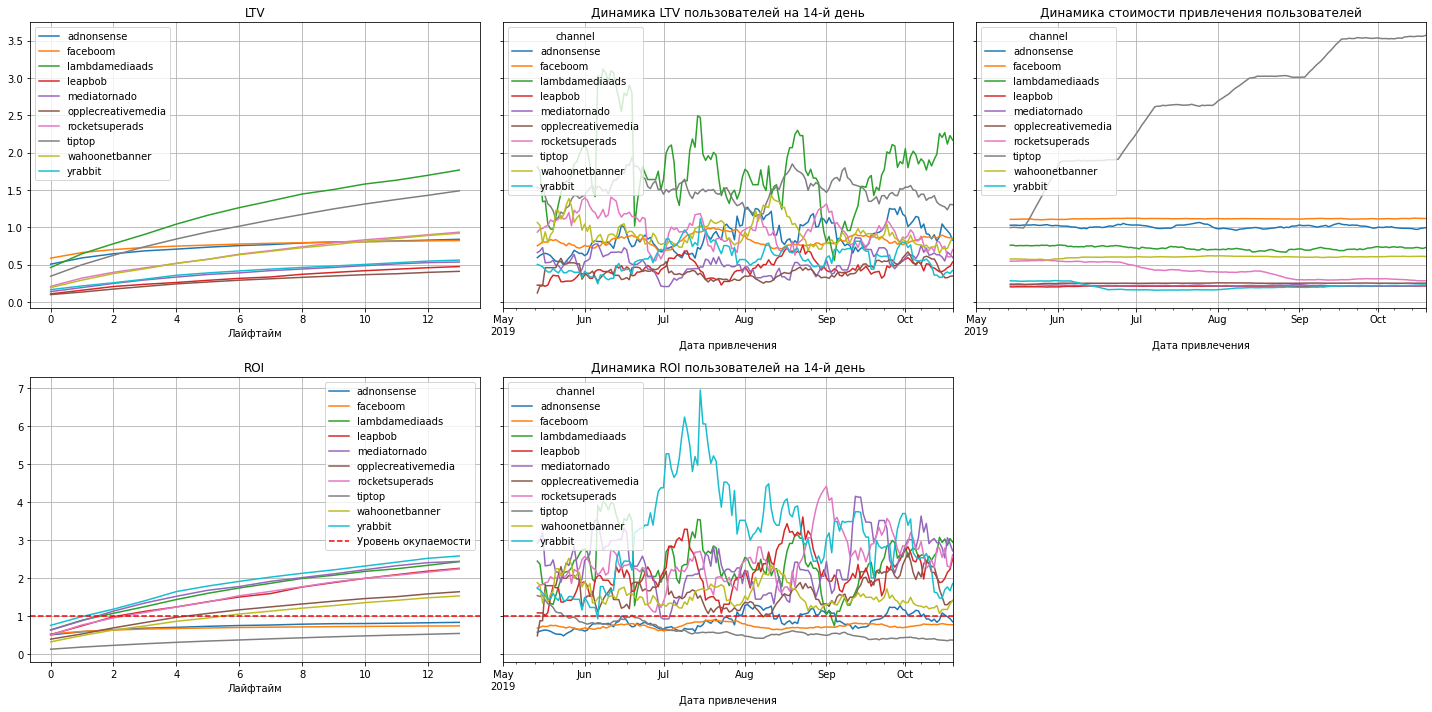

In [55]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Данный срез позволяет нам определить 3 неэффективных рекламных канала: tiptop, faceboom и adnonsense. При этом tiptop выделяется еще и ступенчатым скачкообразным перманентным ростом стоимости привлечения пользователей, начиная с той самой середины мая, которое уже несколько раз привлекало наше внимание. По всем остальным каналам, рекламные вложения окупаются, но, поскольку те самые аутсайдеры маркетинга, являются у нас самыми большими поставщиками пользователей, наглядно видна причина неэффективной траты рекламного бюджета. 
К 6 дню рекламные вложения окупаются у всех каналов, кроме 3 вышеназванных.
Летом отлично себя проявил канал yrabbit. 

Поскольку именно в этом срезе так явно видны проблемы, построим несколько дополнительных графиков подтверждающих наши выводы.

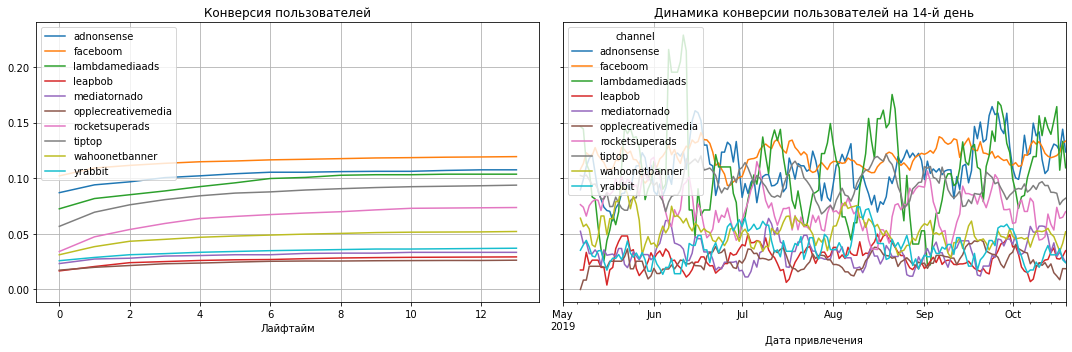

In [56]:
#изучим конверсию с разбивкой по каналам привлечения
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Графики конверсии не показывают ничего необычного. Есть каналы с неплохой конверсией, есть каналы середнячки. Но в целом, никто сильно не выпадает.

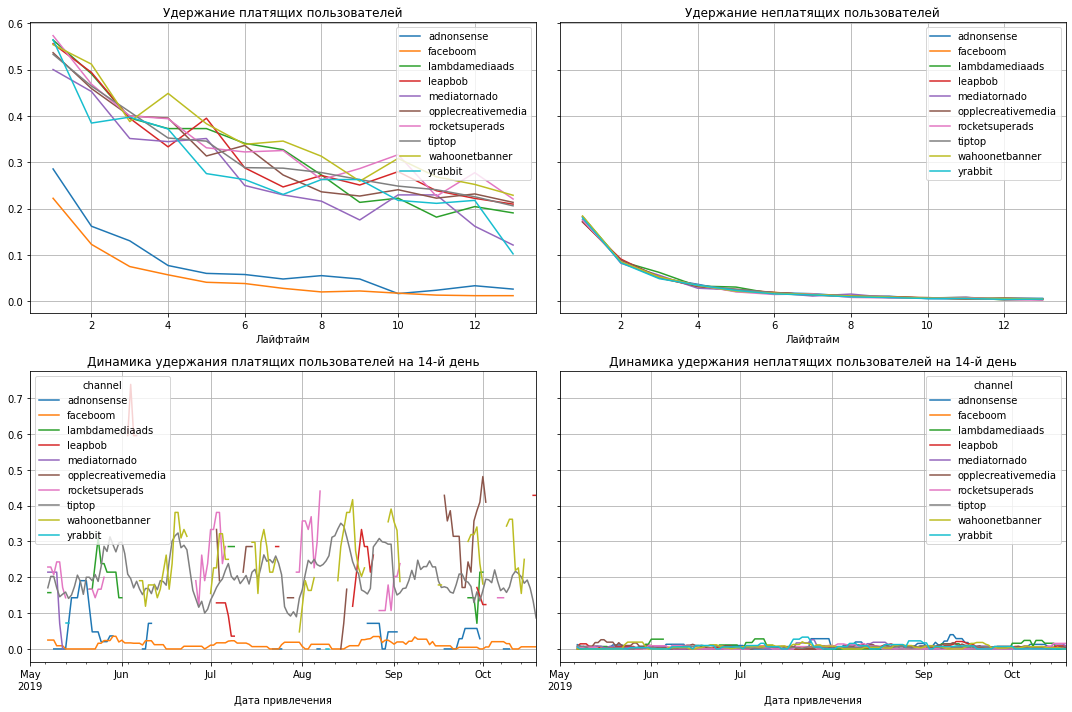

In [57]:
#удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Дополнительные графики наглядно демонстирурют нам проблемы с удержанием пользователей пришедщих через каналы faceboom и adnonsense. Уровень удержания таких пользователей находится на уровне обычных неплатящих пользователей.

#### Дополнительный анализ рынка США

В ходе исследования мы выявили явные пробелемы и отличия рынков США и европейских стран. Проведем небольшое укрупненное исследование изучив метрики только для рынка США и затем отдельно для рынка Европы.

In [58]:
#выделим профили пользователей США
profiles_usa = profiles.query('region == "usa"')
print(len(profiles_usa))

61829


In [59]:
#проанализируем число привлеченных пользователей по различным каналам
profiles_usa.groupby('channel')['user_id'].count().reset_index()

,channel,user_id
0,faceboom,29144
1,mediatornado,4364
2,rocketsuperads,4448
3,tiptop,19561
4,yrabbit,4312


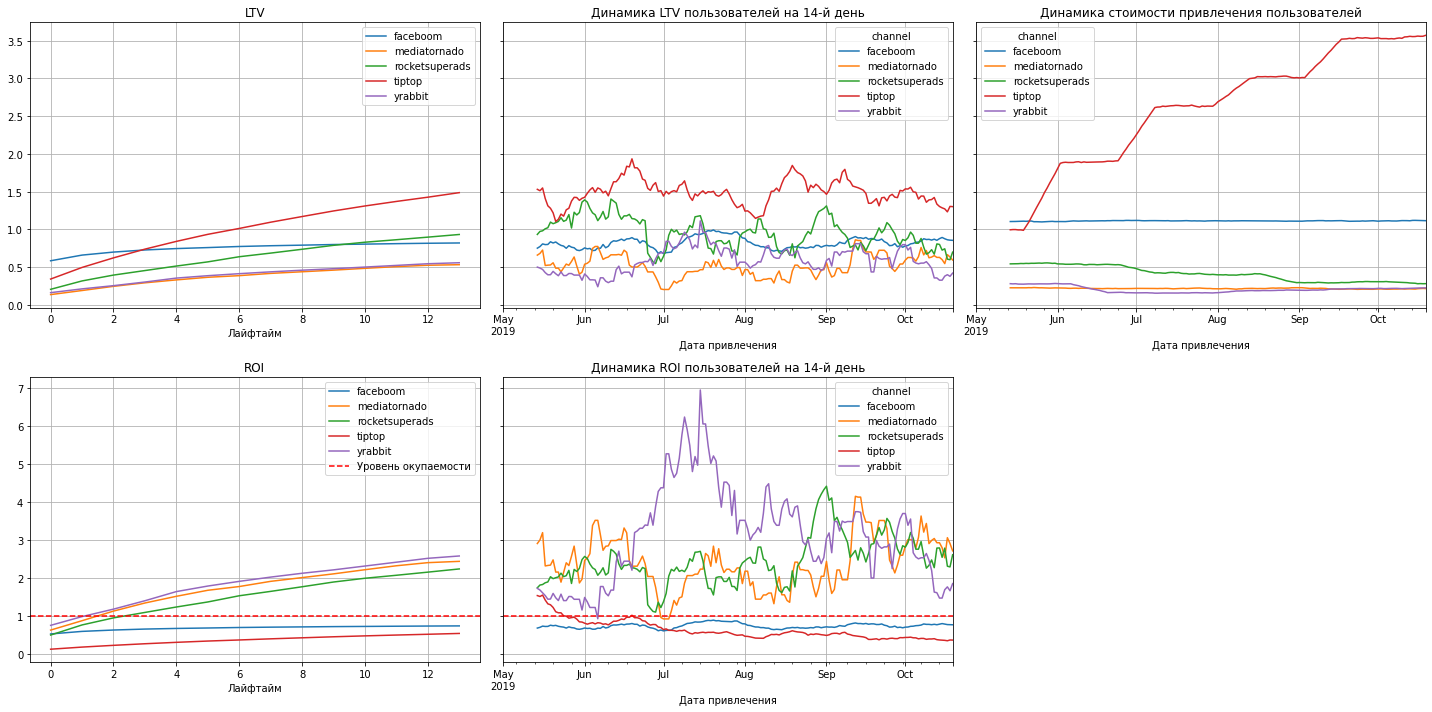

In [60]:
# изучим окупаемость вложений с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Взяв метрики по пользователям США, мы видим, что проблемы возникают не на всем рынке США, а только с двумя каналами привлечения пользователей. Faceboom и особенно tiptop, оба они не окупают вложенные в них средства на протяжении всего приода исследования. При этом tiptop имеет самый высокий LTV среди всех каналов привлечения, но при этом и постоянно растущий и самый высокий на рынке CAC. Получается, что на полученные через этот канал 1,5 у.е., мы тратим около 3,5 у.е. рекламного бюджета. Таким образом ROI находится в районе 50%.

#### Дополнительный анализ рынка Европы

In [61]:
#выделим профили пользователей Европы
profiles_eur  = profiles.query('region != "usa"')
print(len(profiles_eur))

31740


In [62]:
#проанализируем число привлеченных пользователей по различным каналам
profiles_eur.groupby('channel')['user_id'].count().reset_index()

,channel,user_id
0,adnonsense,3880
1,lambdamediaads,2149
2,leapbob,8553
3,opplecreativemedia,8605
4,wahoonetbanner,8553


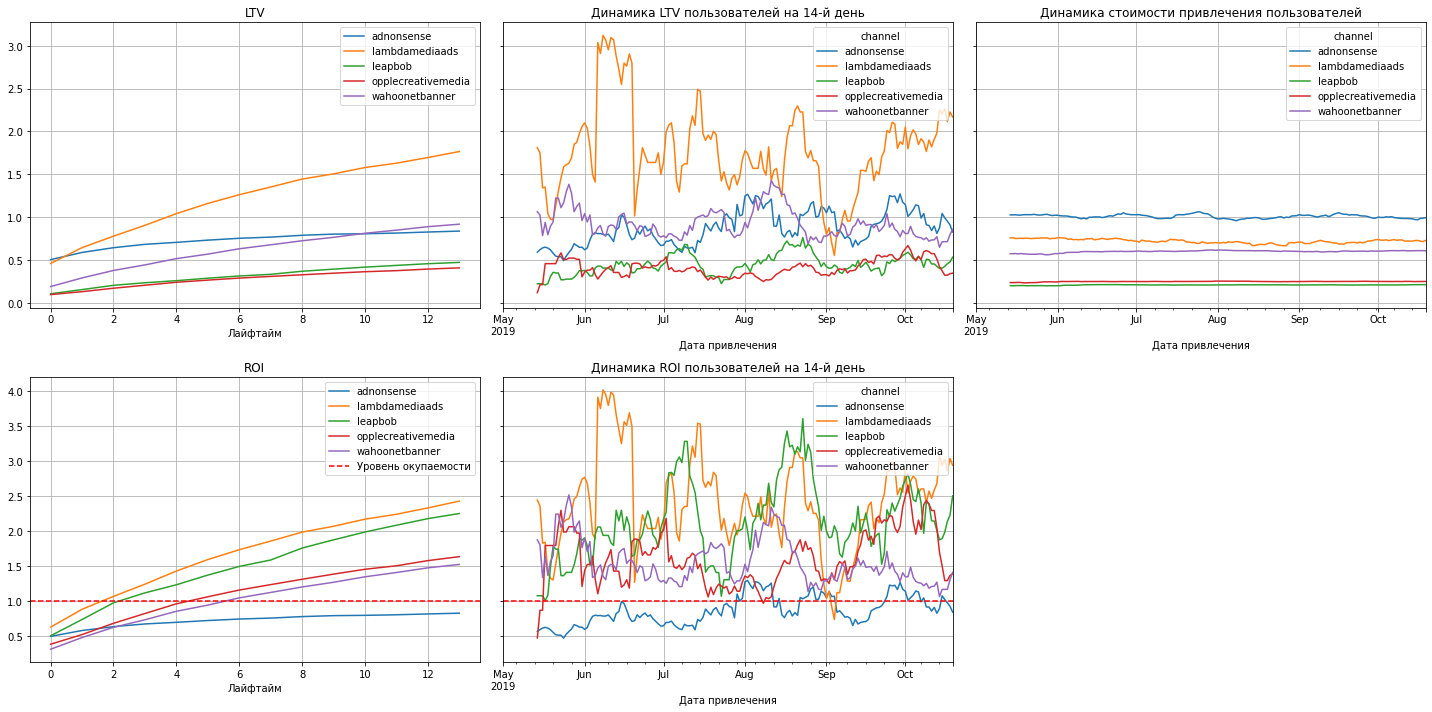

In [63]:
# изучим окупаемость вложений с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eur, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В целом, можно сказать, что ситуация на рынке Европы хорошая почти у всех каналов продвижения. Единственный проблемный канал adnonsense. Не окупает затраты на рекламу при самой высокой цене размещения. В противоположность плохим новостям, можем порадоваться успехам каналов lambdasmediaads и leapbob. Оба выходят в + уже на второй день, а lambdasmediaads демонстирирует еще и отличные показатели LTV. 

#### Вывод по разделу

Общие вложения в рекламу, не окупаются и находятся на уровне 80% от вложенных средств. На данный показатель негативно влияет ситуация сложившаяся с привлечением на рынке США, который для нашего приложения является основным. При этом устройства не влияют на эффективность рекламы, зато критично влияют каналы продвижения и привлечения пользователей. По результатам исследования выяснилось, что основные каналы привлечения неэффектинвы и крайне дороги. Проблемы возникают с пользователями привлеченными через каналы tiptop, faceboom и adnonsense и если последний генерирует совсем несущественное количество пользователей, то tiptop и faceboom являются основными кналами рекламы нашего приложения. Faceboom имеет критические проблемы с удержанием пользователей. Возможно это изначально не наша аудитория, или причина в другом. Но определенно стоит пересмотреть стратегию сотрудничества с данными агентствами.

### Общие выводы по исследованию

Выделите причины неэффективности привлечения пользователей.
Сформулируйте рекомендации для отдела маркетинга.
В рамках исследования неэффективного расходования больших рекламных вложений в продвижение приложения Procrastinate Pro+ мы проанализировали данные пользователях, привлечённых с 1 мая по 27 октября 2019 года. Мы выяснили откуда приходят пользователи и какими устройствами они пользуются, сколько стоит привлечение пользователей из различных рекламных каналов, когда окупаются расходы на привлечение клиента.

Датасет изначально был хорошего качества, без пропусков и дубликтов, поэтому на этапе предобработки понадобились лишь небольшие стилистические изменения написаний текстовой информации и перевод столбцов хранящих дату и время в удобный для анализа формат данных. Пользователи нашего приложения приходят из четырёх стран: Великобритания, Германия, США и Франция. Наибольшее число пользователей приложения из США (~67%), за которыми и лучшее соотношение платящих пользователей ~ 7%. В странах Европы доля платящих пользователей находится в районе 4%.

Пользователи пользуются 4 типами устройств для входа в приложение: Android, iPhone, MAC, PC. Наибольшее число пользователей приходит в приложение с iPhone - 36%, однако по доле платящих пользователей, айфон чуть проигрывает Mac ~ 6.4%, в то время как у iPhone ~ 6.2%

Мы имеем 11 каналов привлечения пользователей (включая "органический" - пользователей, которые нашли наше приложение сами). Если не брать во внимание пользователей пришедших естественым путем, то на первый взгляд, самый продуктивный и эффективный канал привлечения это faceboom - 19% всех пользователей и 12% платящих пользователей приходится именно на этот канал.

За анализируемый период на рекламу было потрачено 105497 у.е. Основные траты на привлечение были сосредоточены на двух источниках - tiptop и faceboom. Рекламные расходы неуклонно и стремительно росли от месяца к месяцу именно по этим двум источникам. Остальные каналы продвижения финансировались на стабильно одинаковом уровне в течение времени. Средняя стоимость привлечения пользователя через канал tiptop достигла ~ 2.8 у.е., что существенно отличается от остальных представленных каналов продвижения приложения.

Общие вложения в рекламу, не окупаются и находятся на уровне 80% от вложенных средств. На данный показатель негативно влияет ситуация сложившаяся с привлечением на рынке США, который для нашего приложения является основным. При этом устройства не влияют на эффективность рекламы, зато критично влияют каналы продвижения и привлечения пользователей. По результатам исследования выяснилось, что основные каналы привлечения неэффектинвы и крайне дороги. Проблемы возникают с пользователями привлеченными через каналы tiptop, faceboom и adnonsense и если последний генерирует совсем несущественное количество пользователей, то tiptop и faceboom являются основными кналами рекламы нашего приложения. Faceboom имеет критические проблемы с удержанием пользователей. Возможно это изначально не наша аудитория, либо какие-то особенности аудитории именно рынка США мешают нашему активному продвижению. Но определенно стоит пересмотреть стратегию сотрудничества с данными агентствами.

Рекомендации: Основным рынком нашего приложения на данный момент является США и проблемы с рекламным бюджетом начинаются с середины мая 2019 года, когда начинается рост стоимости привлечения новых клиентов через одно из рекламных агенств, что негативно влияет на данные по всему приложению в целом. При этом, пользователи показывают хороший уровень конверсии и LTV, но плохое удержание именно на рынке США.

В качестве рекомендаций можно посоветовать изучить наш продукт на предмет разницы пользовательских предпочтений в регионах Европа и США. Возможно сейчас в приложении преобладают платные услуги более востребованные в странах Европы, чем в США.
Возможно стоит разработать какую-то программу лояльности, или бонусов именно для повышения удержания пользователей из США.
Стоит изучить технические особенности платформ iPhone и Mac на предмет потенциальных технических проблем, влияющих на лояльность клиентов на рынке США, поскольку эти две платформы наиболее используемы именно на американском рынке.
Категорически стоит пересмотреть формы сотрудничества с платформами faceboom и tiptop, которые съедают львиную долю рекламного бюджета с крайне неэффективной отдачей на выходе. Стоит разобраться как они продвигают наш продукт, что изменилось с сердины мая, когда цена пошагала вверх, а эффективность вниз.
Наше приложение демонстирует хорошие показатели окупаемости в трех странах Европы. Возможно стоит расширить присутсвие в этом регионе и на другие страны, кроме уже представленных. Или заняться более активным продвижением в странах присутствия (скорректировав при этом работу с европейским рекламным агентством adnonsense, показывающим плохие результаты работы).